## Binary Search Trees

We have seen before how we can use binary search to perform quick range queries over the population of all known places.

### Trees

Instead of binary search on a sorted array, we can achieve the same speed (albeit using more memory) by organizing the population index as a [binary search tree](https://en.wikipedia.org/wiki/Binary_search_tree): Each node stores two (hence, _binary_) child nodes, where all nodes on the left have a lower or equal population, and all nodes on the right have a equal or greater population.

[![Example Graph](figures/Binary%20Tree%20by%20Population.svg)](http://magjac.com/graphviz-visual-editor/?dot=digraph%20BST_Pop%20%7B%0A%20%20%20%20rankdir%3DTB%3B%20ordering%3Dout%3B%0A%09node%20%5Bshape%20%3D%20circle%3B%20width%3D1%3B%20fixedwidth%3Dtrue%5D%3B%0A%0A%20%20%20%20Seoul%5Blabel%3D%3Cpop%3A%2010349312%3CBR%2F%3E%5CN%3E%5D%0A%20%20%20%20Moscow%5Blabel%3D%3Cpop%3A%2010381222%3CBR%2F%3E%5CN%3E%5D%0A%20%20%20%20Wuhan%5Blabel%3D%3Cpop%3A%2010392693%3CBR%2F%3E%5CN%3E%5D%0A%20%20%20%20Tianjin%5Blabel%3D%3Cpop%3A%2011090314%3CBR%2F%3E%5CN%3E%5D%0A%20%20%20%20Karachi%5Blabel%3D%3Cpop%3A%2011624219%3CBR%2F%3E%5CN%3E%5D%0A%20%20%20%20S%C3%A3o_Paulo%5Blabel%3D%3Cpop%3A%2012400232%3CBR%2F%3ES%C3%A3o%20Paulo%3E%5D%0A%20%20%20%20Chengdu%5Blabel%3D%3Cpop%3A%2013568357%3CBR%2F%3E%5CN%3E%5D%0A%20%20%20%20%0A%0A%20%20%20%20Tianjin%20-%3E%20Moscow%20%5Blabel%3Dleft%5D%3B%0A%20%20%20%20Tianjin%20-%3E%20S%C3%A3o_Paulo%20%5Blabel%3Dright%5D%3B%0A%20%20%20%20Moscow%20-%3E%20Seoul%20%5Blabel%3Dleft%5D%3B%0A%20%20%20%20Moscow%20-%3E%20Wuhan%20%5Blabel%3Dright%5D%3B%0A%20%20%20%20S%C3%A3o_Paulo%20-%3E%20Karachi%20%5Blabel%3Dleft%5D%3B%0A%20%20%20%20S%C3%A3o_Paulo%20-%3E%20Chengdu%20%5Blabel%3Dright%5D%3B%0A%0A%7D%0A)

We are going to build such a tree below. One crucial part is finding the right nodes such that the tree is approximately balanced and does not degenerate into a _vine_:

![BST Vine](figures/bst-vine.png)

Ideally, the root node is is chosen as the median population of all cities, so that each subtree contains the same number of entities - we say the tree is _balanced_. The same procedure can recursively be applied to each half of the remaining entities.

In [1]:
# Toy dataset

towns = {
    0: {'name': 'Romanshorn', 'population': 11556, 'latitude': 47.56586, 'longitude': 9.37869},
    1: {'name': 'Amriswil', 'population': 14313, 'latitude': 47.54814, 'longitude': 9.30327},
    2: {'name': 'Arbon', 'population': 15459, 'latitude': 47.51360, 'longitude': 9.42999},
    3: {'name': 'Weinfelden', 'population': 11893, 'latitude': 47.56638, 'longitude': 9.10588},
    4: {'name': 'Frauenfeld', 'population': 26093, 'latitude': 47.55856, 'longitude': 8.89685},
    5: {'name': 'Kreuzlingen', 'population': 22788, 'latitude': 47.645837,'longitude': 9.178608},
    6: {'name': 'Egnach', 'population': 4897, 'latitude': 47.54565, 'longitude': 9.37864},
}

### BST Nodes
A binary node with two children, a key, and a value (payload).

In [2]:
class BstNode():
    """Invariant: All keys in left subtree are <= key, all keys in right subtree are >= key."""
    def __init__(self, key, value):
        self.left = None
        self.right = None
        self.key = key
        self.value = value

### Building a Tree

Use the list of elements sorted by the search dimension - always use the median of the remaining list as the next node. Build the tree recursively.

In order to find the median, we first need to create a list of all (population, id) tuples sorted by population.

In [3]:
# Lets sort the tuples
sorted_by_population = []
for id,town in towns.items():
    tuple_population_id = (town['population'], id)
    sorted_by_population.append(tuple_population_id)

sorted_by_population.sort()
sorted_by_population

[(4897, 6),
 (11556, 0),
 (11893, 3),
 (14313, 1),
 (15459, 2),
 (22788, 5),
 (26093, 4)]

In [4]:
def build_bst(sorted_tuples, lower, upper):
    """Include all elements in sorted_tuples from lower to upper indices (inclusive)."""
    if lower > upper:
        return None
    median_index = (lower + upper) // 2
    median_element = sorted_tuples[median_index]
    node = BstNode(median_element[0], median_element[1])
    node.left = build_bst(sorted_tuples, lower, median_index - 1)
    node.right = build_bst(sorted_tuples, median_index + 1, upper)
    return node

tree = build_bst(sorted_by_population, 0, len(sorted_by_population)-1)

### Tree Traversal
Let's walk the tree in-order.

#### Generators
We could print all elements as we go; easier is to use `yield` and `yield from` instead, such that the tree traversal function becomes a _generator_. A python generator is something that can be iterated over (with a `for`-loop). Computation of each element in the iteration is deferred until the loop actually requests it. The generator internally keeps track of the iteration state; in our case: where in the tree we were when the previous element was requested.

The `yield` statement will "return" an element to one iteration request, and execution will continue after the yield statement for the next request.

The `yield from` statement is similar, but will exhaust the generator it is called for, before continuing after the statement for any subsequent invocation.

Read more on [`yield` on python.org](https://docs.python.org/3/reference/expressions.html#yield-expressions).

In [5]:
def walk_tree(node):
    if node is None:
        return
    yield from walk_tree(node.left)
    yield node
    yield from walk_tree(node.right)

for node in walk_tree(tree): print(node.key, node.value, towns[node.value]['name'])

4897 6 Egnach
11556 0 Romanshorn
11893 3 Weinfelden
14313 1 Amriswil
15459 2 Arbon
22788 5 Kreuzlingen
26093 4 Frauenfeld


### Visualize

Let's use graphviz to render a visualization of the tree.

Note: you may need to restart the kernel to use updated packages.


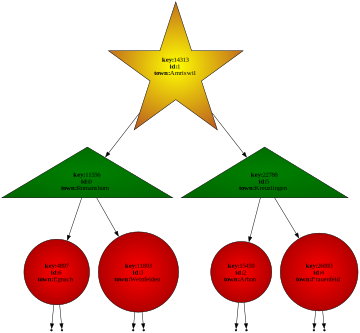

In [45]:
%pip install graphviz
import graphviz

def render_tree(graph, node, nuller="", depth=0):
    """Renders the tree in graphviz."""
    if node is None:
        # In order to have separate Nil-nodes, we need to create artificially
        # named nodes with unique names. We use the 'nuller' parameter to create
        # these, which is the left/right-path down from the root.
        graph.node(nuller, "", shape="point")
        return nuller

    # Christmas Special: Add season's colors & shapes... :)
    if depth == 0:
        dot.attr('node', shape='star')
        dot.attr('node', fillcolor='yellow:brown')
    elif depth == 2:
        dot.attr('node', shape='circle')
        dot.attr('node', fillcolor='red:darkred')
    else:
        dot.attr('node', shape='triangle')
        dot.attr('node', fillcolor='green:darkgreen')

    id = str(node.key)
    graph.node(id, f"< <B>key:</B> {id}<BR/><B>id:</B> {str(node.value)}<BR/><B>town:</B> {towns[node.value]['name']} >")

    left_key = render_tree(graph, node.left, nuller + "l", depth+1)
    graph.edge(id, left_key)
    right_key = render_tree(graph, node.right, nuller + "r", depth+1)
    graph.edge(id, right_key)
    return id

dot = graphviz.Digraph("Population Search Tree")
dot.attr('node', style='radial')
dot.attr(size='5!,5!')  # Size in inches

render_tree(dot, tree)
dot

### Querying

Now let's query the tree index! We want to retrieve nodes _in-order_, similar to the tree walk above. Again, recursion and yield makes the implementation pretty neat.
  * If the search key (or lower bound of the search range) is less or equal than a node's `key`, we keep searching to the `left`.
  * If the node's key matches the query, we include this node's value in the result set.
  * If the search key (or upper bound of the search range) is greater or equal than the node's `key`, we keep searching to the `right`.
  * If the node is `None`, we were called for a non-existing node (the child of a leaf) and should simply return.

In [14]:
def tree_search(node, lower, upper):
    """Traverses tree in-order from lower to upper key."""
    if node is None:
        return  # reached a leaf node
    if lower <= node.key:
        # return elements on our left
        yield from tree_search(node.left, lower, upper)
    if lower <= node.key <= upper:
        yield node  # return this node
    if node.key <= upper:
        # return elements on our right
        yield from tree_search(node.right, lower, upper)

for node in tree_search(tree, 5000, 13000):
    entity = towns[node.value]
    print(entity['name'], entity['population'])


Romanshorn 11556
Weinfelden 11893
